# FargoCPT Selfgravity

This notebook guides you enabling self-gravity and plotting the accelerations.

First we create a new directory and change to it.

In [1]:
example_name = "401_Selfgravity"
import os
if not os.path.basename(os.getcwd()) == example_name:
    !mkdir -p $example_name
    os.chdir(example_name)
print("We are currently in", os.getcwd())

We are currently in /home/rometsch/repo/fargocpt/examples/401_Selfgravity


## Make sure the code is built by running make again.

In [2]:
%%timeit -n1 -r1
from sys import platform
if platform in ["linux", "darwin"]:
    !make -j 4 -C ../../src > make.log
else:
    raise RuntimeError(f"Seems like you are not running MacOS or Linux but {platform}. This is unsupported. You are on your own, good luck!")

117 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Preparing a setup file

We'll take the example setup file from the examples directory and modify it in python.
If you want to create setup files for a parameter study, just copy the code and make your own setup creator script.

In [3]:
configfile = "setup.yml"
!cp ../config.yml $configfile

We'll use the `ruamel.yaml` package to read and write the setup file. This can be set up to preserve comments which is very useful if you want to trace your decisions later on.

In [4]:
try:
    import ruamel.yaml
except ImportError:
    raise ImportError("Please install ruamel.yaml with `python3 -m pip install ruamel.yaml`")
yaml = ruamel.yaml.YAML()
with open(configfile, "r") as infile:
    config = yaml.load(infile)

In [5]:
config["nbody"][1]["accretion efficiency"] = "2"
config["MonitorTimestep"] = 0.314 # monitor scalar files around every half orbit
config["Nmonitor"] = 20 # write a snapshot every orbit
config["Nsnapshots"] = 10 # wirte 100 snapshots
# use very low resolution by setting it to 2 cell per scaleheight, cps

# config["Nrad"] = 100
# config["Naz"] = 100
config["cps"] = 2

config["WriteSGAccelRad"] = "yes"
config["WriteSGAccelAzi"] = "yes"
config["WriteToomre"] = "yes"

config["SelfGravity"] = "yes"
# select the self-gravity mode, 'besselkernel' is likely what you want
# you can also choose 'symmetric', or 'basic' (warning: this is a non-symmetric force)
config["SelfGravityMode"] = "besselkernel"
# if you run a simulation with an non-isothermal equation of state, the following parameter sets 
# the number of hydrosteps between kernel updates
# config["SelfGravityStepsBetweenKernelUpdate"] = 10


with open(configfile, "w") as outfile:
    yaml.dump(config, outfile)

## Run the simulation

In [6]:
from fargocpt import run
run(["start", configfile], np=2, nt=1, exe="../../bin/fargocpt_exe", detach=False)

Running command: mpirun -np 2 --report-pid /tmp/tmp9qe4bw0_ -x OMP_NUM_THREADS=1 ../../bin/fargocpt_exe start setup.yml
fargo process pid 1390537

[0] MPI rank #  0 runs as process 1390541
[1] MPI rank #  1 runs as process 1390542
[1] MPI rank #  1 OpenMP thread #  0 of  1 on cpt-kamino
[0] MPI rank #  0 OpenMP thread #  0 of  1 on cpt-kamino
[0] fargo: This file was compiled on Nov 14 2023, 12:56:40.
[0] fargo: This version of FARGO used _GNU_SOURCE
[0] fargo: This version of FARGO used NDEBUG. So no assertion checks!
[0] Using parameter file setup.yml
[0] Computing disk quantities within 5.00000e+00 L0 from coordinate center
[0] BC: Inner composite = reflecting
[0] BC: Outer composite = reflecting
[0] BC: Sigma inner = zerogradient
[0] BC: Sigma outer = zerogradient
[0] BC: Energy inner = zerogradient
[0] BC: Energy outer = zerogradient
[0] BC: Vrad inner = reflecting
[0] BC: Vrad outer = reflecting
[0] BC: Vaz inner = keplerian
[0] BC: Vaz outer = keplerian
[0] DampingTimeFactor: 1.

0

In [7]:
print(os.listdir(config["OutputDir"]))
snapshots = os.listdir(config["OutputDir"]+ "/snapshots")
snapshots.sort()
print(snapshots)

['parameters', 'snapshots', 'fargocpt_output_v1_4', 'used_rad.dat', 'constants.yml', 'info2D.yml', 'monitor', 'dimensions.dat', 'info1D.yml', 'logs', 'units.yml']
['0', '1', '10', '2', '3', '4', '5', '6', '7', '8', '9', 'list.txt', 'reference', 'timeSnapshot.dat']


Following is an overview widget for the simulation. You can use the slider to scrub through the different snapshots.

In [8]:
import sys
sys.path.append("../../Tools")
from overview import Overview

Run the next cell again to refresh the snapshot list.

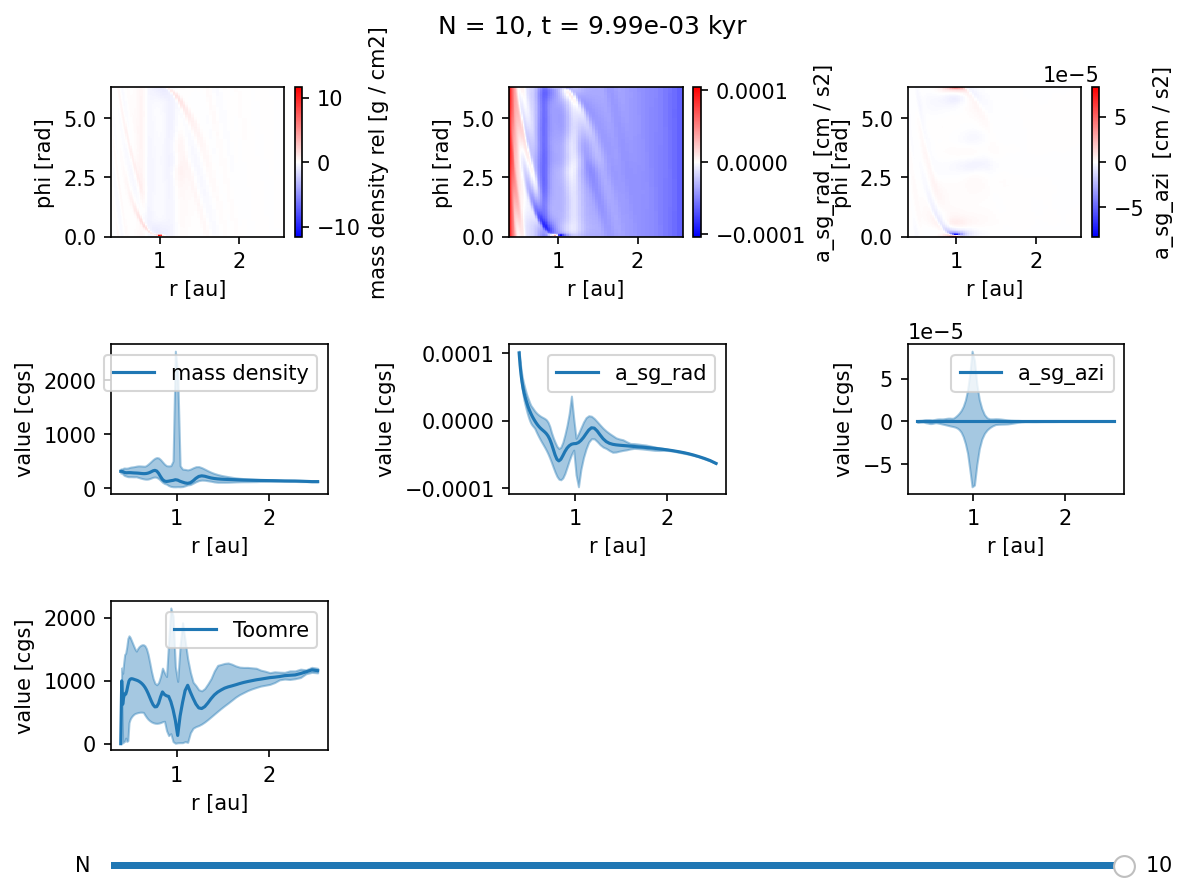

In [9]:
overview = Overview("output/out/", 
                    vars=["2:mass density:rel,rphi",
                          "2:a_sg_rad:rphi",
                          "2:a_sg_azi:rphi",
                          "1:mass density:minmax",
                          "1:a_sg_rad:minmax",
                          "1:a_sg_azi:minmax",
                          "1:Toomre:minmax"])
overview.create();

## Visualizing SG accelerations

We turned on output of the self-gravity accelerations.
Let's have a look.

In [10]:
import numpy as np
import matplotlib.colors as mplcolors
import matplotlib.pyplot as plt

def plot_field(data, name, N, ax=None, dataunit=None, vmin=None, vmax=None, cmap="viridis", title=None):
    field = data.get(var=name, dim="2d", N=N)
    if dataunit is None:
        dataunit = field.data.unit
    Z = field.data.to_value(dataunit)

    ri = field.grid.get_interfaces("r").to_value("au")
    phii = field.grid.get_interfaces("phi").to_value("rad")
    PHI, R = np.meshgrid(phii, ri)
    X = R*np.cos(PHI)
    Y = R*np.sin(PHI)

    if ax is None:
        fig, ax = plt.subplots(dpi=150)
    else:
        fig = ax.get_figure()

    norm = mplcolors.Normalize(vmin=vmin, vmax=vmax)
    pcm = ax.pcolormesh(X,Y,Z, norm=norm, cmap=cmap)
    ax.set_aspect("equal")

    t = field.time.to_value("kyr")
    if title is None:
        title = ""
    else:
        title += "\n"
    title += f" t={t:.2e}kyr, N={N}"
    ax.set_title(title)

    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(f"{name} [{dataunit}]")
    
    return fig

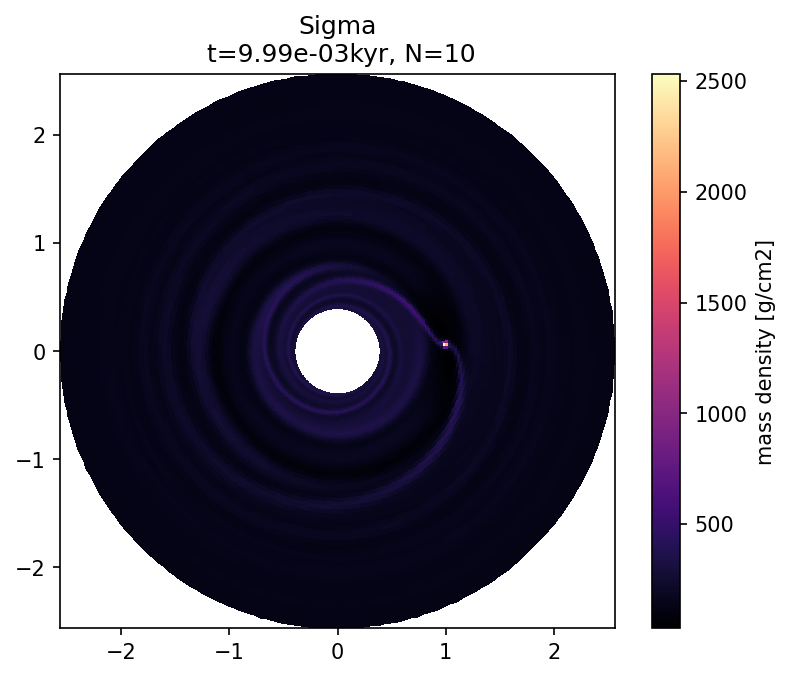

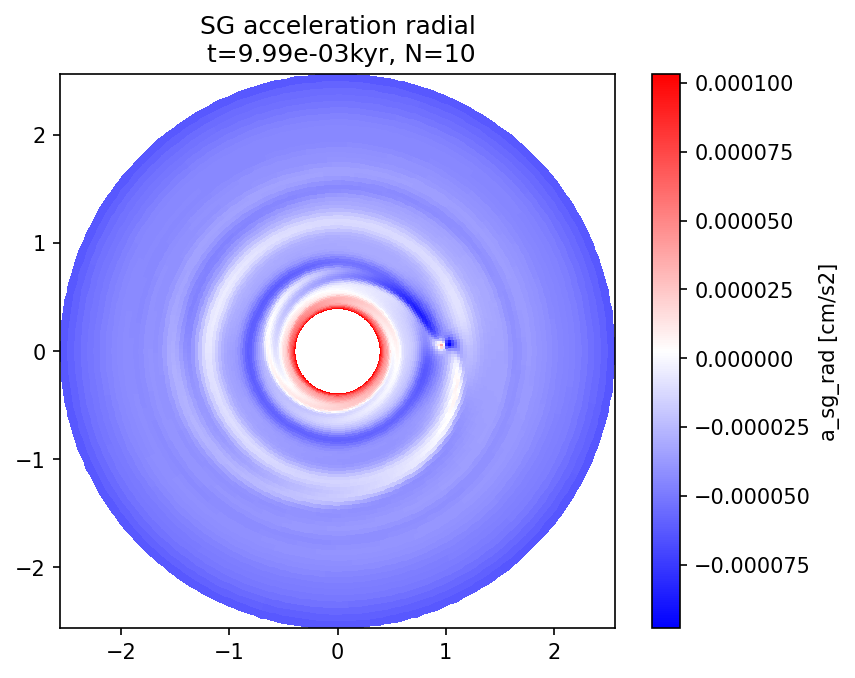

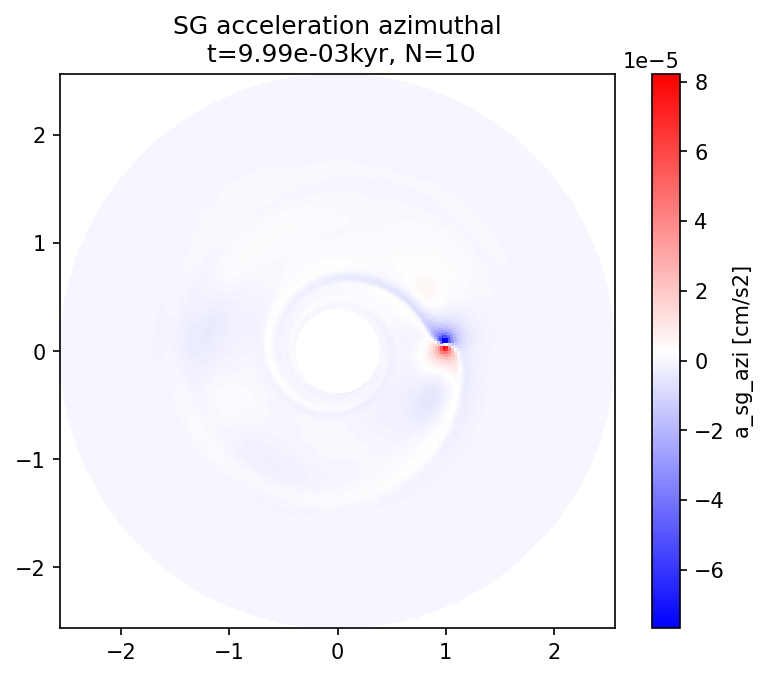

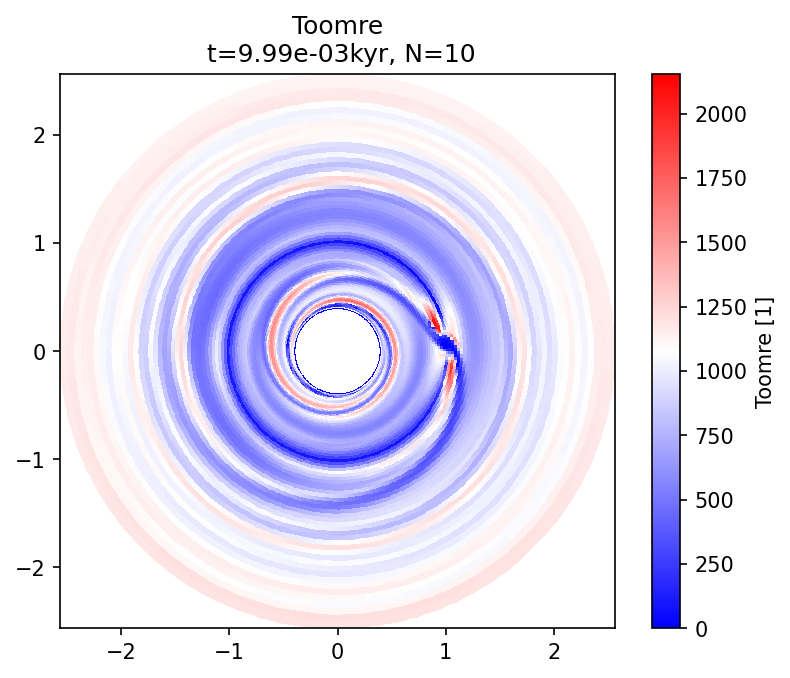

In [11]:
import disgrid
d = disgrid.Data("output/out/")
Nlast = d.avail()["Nlast"]
plot_field(d, "mass density", Nlast, dataunit="g/cm2", cmap="magma", title="Sigma");
plot_field(d, "a_sg_rad", Nlast, dataunit="cm/s2", cmap="bwr", title="SG acceleration radial");
plot_field(d, "a_sg_azi", Nlast, dataunit="cm/s2", cmap="bwr", title="SG acceleration azimuthal");
plot_field(d, "Toomre", Nlast, dataunit="1", cmap="bwr", title="Toomre");

We can also get the data through the build in data Loader.

In [12]:
from fargocpt import Loader

In [13]:

l = Loader("output/out/")
l

   Loader
| output_dir: output/out/
| snapshots: 0 ... 10
| special_snapshots: ['reference']
| snapshot_time: 0.0 5.02257e+06 s ... 62.8 5.02257e+06 s
| monitor_number: 0 ... 200
| units: Units
| target_units = None
| gas: Hydro
| nbody: Nbody
| params: Params
| particles = None

In [14]:
l.gas.vars1D

   Vars1D
| output_dir: output/out/
| target_units= None
| grid: Grid
| var_names:
|   Sigma
|   vrad
|   vazi
|   energy
|   a_sg_rad
|   a_sg_azi
|   Toomre

In [20]:
R, Phi, ASGR = l.gas.vars2D.get("a_sg_rad", l.snapshots[-1], grid_for_plot=True)

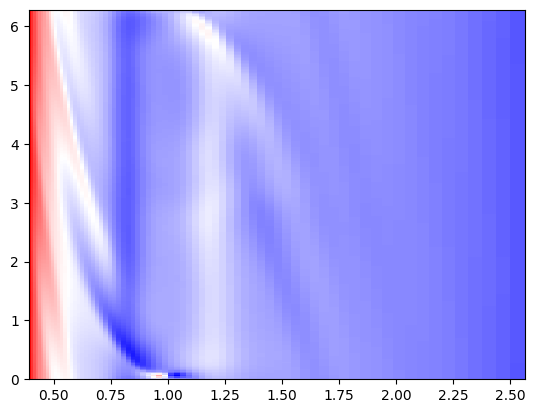

In [23]:
plt.pcolormesh(R.to_value("au"), Phi, ASGR.value, cmap="bwr")